## <center> Data Preparation and Model Training</center>

Sample data: 

* 
> “A-M-A-ZING!!!!!!!!!!!!!! LOVE THIS PLACE!!!!!!! Everything on the menu looked so good!! Garlic chicken was the BOMB!!!!!! MUST EAT AT THIS PLACE!!! I recommend ordering ahead before you go! Gets very busy!!!” — 5 Stars.

* 
> “burgers are very big portions here. definitely order the onion ring tower to share…Milkshakes are tasty! My personal favourite — the vanilla one.” — 3 Stars.

* 
> “Food is very bland — not authentic at all. meant to cater to the customers who have never eaten Vietnamese food before. Definitely will not be returning!” — 1 Stars

The first part of the project is to prepare the data. As we saw in the examples above, the reviews are very distinct. 
* Some of them have symbols, 
* have weird punctuation symbols, 
* and some even have non-alphanumeric characters. 

We will clean these and keep the most relevant strings and words from the reviews. 

## Importing libraries

Importing necessary libraries to assist us in data preparation

In [16]:
import pandas as pd    # to create a dataframe from JSON datafile
import json            # to read the dataset, because dataset is initially in the JSON format
import numpy as np     # to handle large python list as numpy arrays - makes the process faster. Used in creating dataFrame
import matplotlib.pyplot as plt # to draw plot - for visualization
from collections import Counter # to counter class distribution in the dataset
import re              # for data cleaning
import seaborn as sns  # for distribution plot
import pickle          # to save tokenizer


from keras.preprocessing.text import Tokenizer # for converting words to numbers
from keras.preprocessing.sequence import pad_sequences # to pad sentences which are less than defined length
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D, Input, Activation
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

pd.set_option('max_colwidth', 300,"html.border",2)  # For aesthetic purposes
from IPython.display import display, HTML           # For aesthetic purposes

## Read the dataset

The dataset downloaded from yelp is in JSON format as below:  
    
* > {"review_id":"v0i_UHJMo_hPBq9bxWvW4w","user_id":"bv2nCi5Qv5vroFiqKGopiw","business_id":"0W4lkclzZThpx3V65bVgig","stars":5,"date":"2016-05-28","text":"Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \n\nThey ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. \n\nGet a half sour pickle and a hot pepper. Hand cut french fries too.","useful":0,"funny":0,"cool":0}

* > {"review_id":"vkVSCC7xljjrAI4UGfnKEQ","user_id":"bv2nCi5Qv5vroFiqKGopiw","business_id":"AEx2SYEUJmTxVVB18LlCwA","stars":5,"date":"2016-05-28","text":"Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly.","useful":0,"funny":0,"cool":0}

It is  a 4.2G file - *review.json* 

I plan to just read the *text* and *stars* from the review and build a pandas dataset out of it.

Let's do this.

In [38]:
def readData(reviewJsonFilePath, outputDataFrameFilePath):
    df = pd.DataFrame(columns=['review','stars'])
    reviews = []    # Aggregated list of reviews
    stars = []      # Aggregated list of stars
    with open(reviewJsonFilePath, "r") as f:
        number_of_records = 0
        for line in f:
            line = json.loads(line)
            reviews.append(line["text"])
            stars.append(line['stars'])
            number_of_records += 1
            
        df["review"] = reviews
        df["stars"] = stars
        
    print ("Number of records read : {0}".format(number_of_records))      
    print ("Sample data : ")
    display(df.head())
    return df
                
            
reviewJsonFilePath = "../data/review.json"
outputDataFrameFilePath = "../data/dataset.csv"
df = readData(reviewJsonFilePath, outputDataFrameFilePath)            

Number of records read : 5261669
Sample data : 


,review,stars
0,"Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \n\nThey ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. \n\nGet a half sour pickle and a hot pepper. Hand cut french fries too.",5
1,Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly.,5
2,Small unassuming place that changes their menu every so often. Cool decor and vibe inside their 30 seat restaurant. Call for a reservation. \n\nWe had their beef tartar and pork belly to start and a salmon dish and lamb meal for mains. Everything was incredible! I could go on at length about how...,5
3,Lester's is located in a beautiful neighborhood and has been there since 1951. They are known for smoked meat which most deli's have but their brisket sandwich is what I come to montreal for. They've got about 12 seats outside to go along with the inside. \n\nThe smoked meat is up there in quali...,5
4,"Love coming here. Yes the place always needs the floor swept but when you give out peanuts in the shell how won't it always be a bit dirty. \n\nThe food speaks for itself, so good. Burgers are made to order and the meat is put on the grill when you order your sandwich. Getting the small burger ...",4


In [39]:
## Saving the dataset file onto disk for future use
df.to_csv(outputDataFrameFilePath, index=False)

## Class distribution

Let us look at the class distribution of label - *stars* in our case

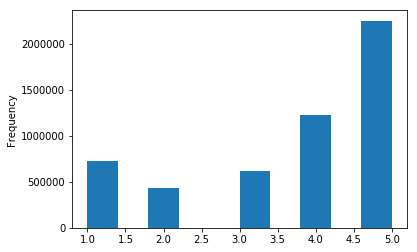

In [2]:
#df = pd.read_csv("../data/dataset.csv")
df['stars'].plot.hist()
plt.show()

In [12]:
c = Counter(df['stars'])
print (c)
print ("Percentage distribution of labels : ")
[(i, c[i] / len(df) * 100.0) for i in c]

Counter({5.0: 2253348, 4.0: 1223316, 1.0: 731363, 3.0: 615481, 2.0: 438161, nan: 1, nan: 1})
Percentage distribution of labels : 


[(nan, 1.900536920685463e-05),
 (1.0, 13.899823839232821),
 (2.0, 8.327411577044632),
 (3.0, 11.697443644804094),
 (4.0, 23.249572236652575),
 (5.0, 42.82571069152746),
 (nan, 1.900536920685463e-05)]

There is definately a class bias :
* 14% of the label values are for stars 1
* 8% of the label values for stars 2
* 12% of the label values for stars 3
* 23% of the label values for stars 4
* 42% of the label values for stars 5



## Sampling

We are looking at 2 criteria when creating the dataset for training and testing purposes. 

* First, we skip over all reviews that have 3 stars, because they are neutral and we are only predicting positive or negative sentiment. 
* The second criteria is maintaining equal number of positive and negative reviews. 

If you load in the data directly, you’ll notice that there are a lot more + reviews than — reviews, with almost a 70%-30% split. We want to keep our training data equally balanced. 

In the code below, we sample the same number of reviews, which in this case is 200,000 for each sentiment (positive and negative) : 
* 100,000 - stars 1 (negative sentiment) 
* 100,000 - stars 2 (negative sentiment)
* 100,000 - stars 4 (positive sentiment)
* 100,000 - stars 5 (positive sentiment)

In [3]:
## Shufling the dataset
df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
df.head()

,review,stars
0,"I had a bad experience with a competitor dentist, who refused to provide a standard cleaning. I had shopped around and read countless reviews to find a good dentist. \n\nIts a big office with 10+ dentists. The hygienists are great and well trained. They handle all the billing and scheduling righ...",5.0
1,This is the closest UPS Store to me and about three years ago I had a bad experience and stopped going there. \n\nBasically I was was told the notary would be there at X o'clock and when I went there they told me to my face that they would have NEVER quoted me that time and that person does not ...,4.0
2,"I am absolutely in love with Sambalatte's cappuccino. It's fresh, dark and rich. If you like light and nutty tastes, this is not for you. If you enjoy dark coffee with some milk and foam, you can't go wrong.\n\nThe shop is very photogenic and the coffee mugs were adorable. It has ""Las Vegas' on ...",5.0
3,"My wife and I accidentally stumbled upon this place when going to see a movie one afternoon. We love sushi, saw the word sushi, and decided to head in and we were not disappointed. The atmosphere was nice. The sushi chefs constantly engaged us in humorous and witty conversation. The fish was fre...",2.0
4,Came here during Speedstreet. Needed a place to sit and relax. Was seated promptly. They have a great craft beer selection and we needed some assistance in understanding the various offerings. Waiter was spot on with his recommendations. Pizza was ordered. They were very busy and the food order ...,4.0


In [4]:
negative1 = df[df["stars"]==1].head(100000)
negative2 = df[df["stars"]==2].head(100000)

positive1 = df[df["stars"]==4].head(100000)
positive2 = df[df["stars"]==5].head(100000)

del df   # freeing up memory

df = pd.DataFrame()
df = df.append(negative1)
df = df.append(negative2)
df = df.append(positive1)
df = df.append(positive2)

del negative1
del negative2
del positive1
del positive2

df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
df.head()

,review,stars
0,"Terrible service. With a 30 minute wait, my two friends and I went to the bar to grab a drink. The bartender didn't pay us (or any other patrons) a second of attention for the whole 25 minutes that we waited at the bar. Once we were seated outside, it took about 20 minutes to get our margaritas,...",2.0
1,Be a single woman customer at the bar before the arts and letters series and learn about poor and maybe gender biased service. Terrible and dismissive service. I won't be back.,1.0
2,"just an FYI, when I went they were no longer serving their carpaccio and marrow dish as their guy can't source good marrow anymore. Bummer. \n\nwe had a seared tuna app to start and it was great. lots of sweet/citrus flavours with the tuna. Really good and refreshing. \n\nshared the cacio e pep...",4.0
3,Went there for lunch with my mother - her first time at an Indian restaurant - service and food was really good. Will definitely be back.,4.0
4,We show up about 2 o'clock on a Tuesday and it's pretty slow. When we pulled up there was nobody out front to write our ticket. Sat there in the car for a couple minutes when finally a guy walked out. He's got his phone in his hand and takes his sweet time walking to the car so he can finish his...,1.0


## Data cleaning

Now, for cleaning the data, we take the following steps:

* remove non alpha-numeric characters, 
* remove punctuation, 
* lower-case each word 
    

In [27]:
df['review'] = df['review'].apply(lambda x:re.sub(r'\W+', " ",x))
df['review'] = df['review'].apply(lambda x:x.lower())

df['stars']  = df['stars'].apply(lambda x: 0 if (x==1 or x==2) else 1)
df.to_csv("../data/subset_dataset", index=False)
df.head()

,review,stars
0,i had about 45 minutes before i had to meet some friends so i decided to venture into this museum and check it out it was free and had a c so those were another two pluses the front desk people were really nice and helpful note that if you have bags a backpack you have to leave them upfront in t...,1
1,brazilian waxing for those that knows what this is knows the pain one endures to get this done but the benefits definitely outweighs the pain i had been putting this off for longer than one should and i finally bit the bullet and went to have it done luckily for me i got mine done by none other ...,1
2,on road trips my wife and i try to look for a w restaurants and this one was one of the best it had a truly classic feel without being tacky it was clean and the manager maybe owner delivered our tray and was wiping tables the food root beer on tap was also great after receiving the standard fro...,1
3,40 minutes for 1 chicken sandwich service sucked she was lazy i assume she forgot to put my order in also don t understand the hype w their pizza,0
4,5 out of 5 star hands down you definitely want to give your business to this smoke shop owner him and his son are just absolutely amazing great customer service i look forward to the days where i get to go to smoke and vape lots of variety and popular products one stop shop,1


## Encode text

With cleaned reviews, we now need to generate embeddings for each review. Text data as we have now cannot be directly fed into the model, so we need to: 

* encode each word to a unique numerical value. 

So, a review will be converted from being an array of words to an array of integer values. This can be done by adding an Embedding layer onto the network, but we need to generate that embedding map first.

* Keras provides a Tokenizer module which we can use to encode the texts. 
* After converting the texts to sequences, we can obtain the word_index. 
* We also need the reverse dictionary, so let’s build that as well. 

After this, we can generate encoded reviews by iterating through the texts, and mapping each word to it’s embedding value.

In [56]:
# Complete this part of the code
c = Counter(words)  # Note : 'words' in defined in below cell under 'Standardize text'. Run that cell first
print ("Total number of words in corpus : ", len(c))

Total number of words in corpus :  183248


Below we are vectorizing a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf

In [13]:
max_fatures = 2000
# df = pd.read_csv("../data/subset_dataset")

tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['review'].values)

In [14]:
# saving tokenizer
with open('../data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Standardize text 

The next part is to standardize the reviews.

As you may have seen when loading the data, all of the reviews have different lengths, some have 50 words, some have 100, and some are even larger. We can take a look at a histogram of the review lengths to make the decision on where to cap the reviews.

In [55]:
def countWords(sentences):
    """
    Function to count number of words in each sentence from the given list of sentences
    :param sentences : List(String). List of sentences
    :return: List(Integer). List of number of words in each sentence
    """
    countWords = []
    words = []
    for sentence in sentences:
        countWords.append(len(sentence.split(" ")))
        words.extend(sentence.split(" "))
        
    return countWords[:], words

numberOfWords, words = countWords(df['review'].values[:])
print (numberOfWords[:20])

[130, 227, 106, 30, 55, 77, 32, 36, 134, 36, 17, 94, 280, 369, 95, 685, 324, 37, 67, 38]


/home/saurabh/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


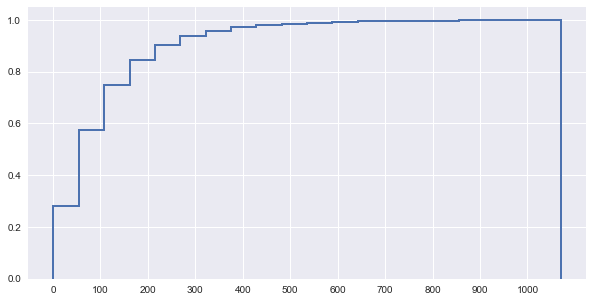

In [41]:
plt.figure(figsize=(10,5))
# plt.title("Cumulative distribution of number of words per sentence")
plt.xticks(np.arange(0, max(numberOfWords)+1, 100.0))
plt.hist(numberOfWords,normed=1,cumulative=True, histtype='step', bins = 20, linewidth=2)
plt.show()

/home/saurabh/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


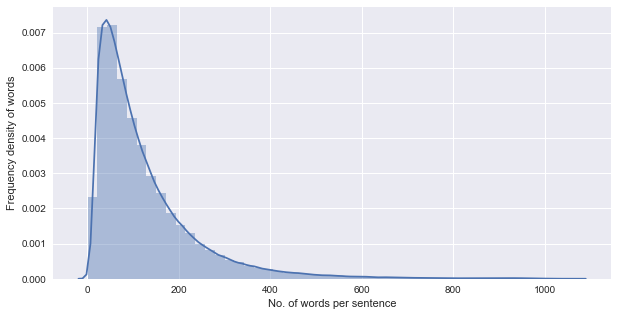

In [42]:
plt.figure(figsize=(10,5))
plt.xlabel("No. of words per sentence")
plt.ylabel("Frequency density of words")
sns.distplot(numberOfWords)
plt.show()

It seems that 300–400 words length reviews encompass our 90% of the dataset. 

300 is going to be a good number to cap the words to. 

Referring to the code below, we will use the function pad_sequences from Keras, which will truncate larger reviews, and pad smaller reviews with zeros, to a maximum cap of 300.

In [2]:
# Complete the code for pad_sequence from keras

# loading tokenizer
with open('../data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

df = pd.read_csv("../data/subset_dataset")
    
X = tokenizer.texts_to_sequences(df['review'].values)
X = pad_sequences(X)

## Shuffle data
From this, we get our X and Y . 

* The labels will be converted to a one-hot-encoding representation. 
* The next step is to shuffle the data. 

To be double sure that data is randomly distributed for + and — reviews, we will shuffle it again. We will use numpy’s random.permuation to shuffle both X and Y equally.

In [44]:
df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
df.head()

,review,stars
0,i had about 45 minutes before i had to meet some friends so i decided to venture into this museum and check it out it was free and had a c so those were another two pluses the front desk people were really nice and helpful note that if you have bags a backpack you have to leave them upfront in t...,4.0
1,brazilian waxing for those that knows what this is knows the pain one endures to get this done but the benefits definitely outweighs the pain i had been putting this off for longer than one should and i finally bit the bullet and went to have it done luckily for me i got mine done by none other ...,5.0
2,on road trips my wife and i try to look for a w restaurants and this one was one of the best it had a truly classic feel without being tacky it was clean and the manager maybe owner delivered our tray and was wiping tables the food root beer on tap was also great after receiving the standard fro...,5.0
3,40 minutes for 1 chicken sandwich service sucked she was lazy i assume she forgot to put my order in also don t understand the hype w their pizza,1.0
4,5 out of 5 star hands down you definitely want to give your business to this smoke shop owner him and his son are just absolutely amazing great customer service i look forward to the days where i get to go to smoke and vape lots of variety and popular products one stop shop,5.0


## Traning, Dev, and Test set

Now we have to divide the reviews into 3 sections: 
* Traning, 
* Dev, and 
* Test set.

The Training data will be used for training the model, and will be majority of the data, 80% (320000 records). Dev data will be used as validation after each training cycle, and is 10% (40000 records), and separate from training so it is unseen. The final 10% (40000 records) is testing data, also unseen and used to verify that the model hasn’t overfitted to Training and Dev. 

In [14]:
# df = pd.read_csv("../data/subset_dataset")
train = df[0:320000]
train.to_csv("../data/train.csv", index=False)

dev = df[320001:360000]
dev.to_csv("../data/dev.csv", index=False)

test = df[360001:]
test.to_csv("../data/test.csv",index=False)

## Defining and Training the model

I compose the LSTM Network - 2 layer with a 100 neurons each.

Note that **embed_dim**, **lstm_out**, **batch_size**, **droupout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. 

Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

With an Adam optimizer, the model was trained using a batch_size of 50. 

In [3]:
embed_dim = 100
lstm_out = 100
max_fatures = 2000

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1012, 100)         200000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1012, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 280,602.0
Trainable params: 280,602.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [4]:
Y = pd.get_dummies(df['stars']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
del df
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(320000, 1012) (320000, 2)
(80000, 1012) (80000, 2)


In [8]:
X_val = X_test[:40000]
Y_val = Y_test[:40000]

In [10]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 4, batch_size=batch_size, verbose = 1, validation_data=(X_val,Y_val))

Train on 320000 samples, validate on 40000 samples
Epoch 1/4
320000/320000 [==============================] - 19621s - loss: 0.2179 - acc: 0.9138 - val_loss: 0.1526 - val_acc: 0.9411
Epoch 2/4
320000/320000 [==============================] - 26063s - loss: 0.1529 - acc: 0.9402 - val_loss: 0.1309 - val_acc: 0.9492
Epoch 3/4
320000/320000 [==============================] - 16543s - loss: 0.1345 - acc: 0.9478 - val_loss: 0.1242 - val_acc: 0.9520
Epoch 4/4
320000/320000 [==============================] - 16275s - loss: 0.1259 - acc: 0.9518 - val_loss: 0.1216 - val_acc: 0.9540


In [11]:
model.save("../data/sentiment_model.hdf5")

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


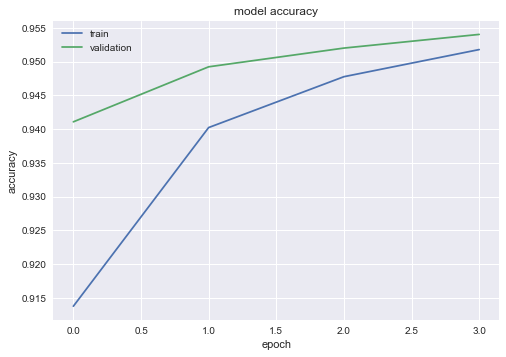

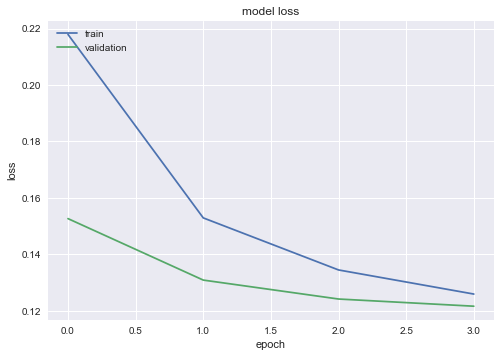

In [19]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Testing on user input

Testing the model on user input sentences/reviews.

GO ahead and try one of your own sentences to see the output.

In [23]:
twt = ['Meetings: Because none of us is as dumb as all of us.',"it suck", "it was bad","i will not come back","will be back"]
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=1012, dtype='int32', value=0)
# print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)
print (sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[0.4622965  0.5377035 ]
 [0.28428844 0.71571153]
 [0.9445617  0.05543826]
 [0.99477506 0.00522494]
 [0.01922075 0.9807793 ]]


The validation error decreases with decrease in training error.

We could only train for 4 epochs, because on my local system, it took 7-8 hrs to train for just 1 epoch.

More epochs could be tried, had we access to GPU which we don't. 

## Training with GloVe Embeddings

The final thing we tried was to change the embeddings. 

In the previous model, we have been using standard embeddings. This means that words that are semantic synonyms have unrelated vector representations. So, if we have the words **Kitchen** and **Dinner**, they could be very far away from each other, while they should be closer since their meaning share a theme. 

To fix this problem, we need to give the encodings values that give words in the same space closer vectors, and distinct words farther vectors.


For this model, we will use GloVe, which generates similar vectorial representations. Instead of training a embedding model from scratch, we will use a pre-trained model here instead. The pre-trained vectors can be obtained from this [Stanford project](https://nlp.stanford.edu/projects/glove/).



<br><br><br>

Several things are happening here, the first of which is reading the glove embeddings. We read them from the text file, splitting them into the word and the vector.

Using the map of words and vectors, we will create an Embeddings Matrix, which will map each of the words in our vocab to the vector for it. Iterating over it, we will build the embeddings matrix by indexing the glove vectors.

Another note here is that the embeddings have a size of 50 for each vector. This means that we would need to re-generate the encoded reviews, call pad_sequences again, and remake X based on the new max_cap.

Moving onto the model, we are changing only one thing, the Embedding layer. We add the parameters weights=[embeddings_matrix] , and trainable=False to make sure that the layer obtains encodings from the GloVe vectors, and does not update the weights during training. After training, I get the following results:

In [3]:
## Building X_train, Y_train, X_test and Y_test

df = pd.read_csv("../data/subset_dataset")
X_train, Y_train = df[0:320000]['review'], df[0:320000]['stars']

X_test, Y_test = df[320001:]['review'], df[320001:]['stars']
print ("Len of training set : ",len(X_train))
print ("Len of testing set : ",len(X_test))

Len of training set :  320000
Len of testing set :  79999


In [5]:
## Converting Y to one-hot

Y_OneHot_Train = pd.get_dummies(Y_train).values
Y_OneHot_Test = pd.get_dummies(Y_test).values

Y_OneHot_Train

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

In [6]:
## Reading Glove Vector

def readGlove(filename):
    """
    Function to read glove vector from the disk and compute word_to_index, index_to_word, and word_to_vec map.    
    Below code is taken from Deep Leaning class of Andrew Ng on coursera.
    
    :param filename : String. e.g. "../data/gloveVec.txt"
    :return : Tuple(dict, dict, dict) .
    """        
    with open(filename, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

words_to_index, index_to_words, word_to_vec_map = readGlove("../data/glove.6B.50d.txt")

In [7]:
## Converting sentences from X_train/X_test into indices vector

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. One can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros(shape=(m, max_len))
    
    for i in range(m):                               
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i].lower().strip().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
            except KeyError as e:
                X_indices[i, j] = word_to_index["unk"]
            # Increment j to j + 1
            j = j + 1
            if j>=max_len:
                break
    
    return X_indices

In [8]:
## Defining pre-training embedding layer to be used in out LSTM Model

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
#     vocab_len = len(words_to_index)                     #using this for twitter glove vectors
    emb_dim = word_to_vec_map["cucumber"].shape[0]      
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        try:
            emb_matrix[index, :] = word_to_vec_map[word]
        except Exception as e:
            print ("Exception {0} occured for word {1}".format(e, word))

    # Define Keras embedding layer with the correct output/input sizes, make it trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer.
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [10]:
## Creating Model

def sentimentify(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the sentimentify model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    sentence_indices = Input(shape=input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)
    spatialDropOut = SpatialDropout1D(0.4)(embeddings)
    
    X = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(spatialDropOut)
    X = Dense(classes, activation='softmax')(X)
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
    
    return model

In [18]:
maxLen = 300
classes = 2
model = sentimentify((maxLen,), word_to_vec_map, words_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 50)           20000050  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 300, 50)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 20,060,652.0
Trainable params: 60,602.0
Non-trainable params: 20,000,050.0
_____________________________________________________

In [19]:
## Compiling the model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [20]:
X_train_indices = sentences_to_indices(X_train, words_to_index, maxLen)

In [ ]:
history2 = model.fit(X_train_indices, Y_OneHot_Train, epochs = 8, batch_size = 50, shuffle=True)

Epoch 1/8
  4700/320000 [..............................] - ETA: 3450s - loss: 0.6848 - acc: 0.5360